# Capstone Project - The Battle of Neighborhoods


## Introduction

New York City ("NYC") is the most densely populated major city in the U.S. with an estimated 8.4 million residents as of July 2018.  NYC's population is about 43% of New York State's population. NYC is often referred to as the five boroughs, and in turn, there are hundreds of distinct neighborhoods throughout the boroughs, many with a definable history and character to call their own. If the boroughs were each independent cities, four of the boroughs (Brooklyn, Queens, Manhattan, and the Bronx) would be among the ten most populous cities in the United States.

Throughout its history, New York City has been a major point of entry for immigrants. The term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side of Manhattan. Approximately 37% of the city's population is foreign born where no single country or region of origin dominates. The ten largest sources of foreign-born individuals in the city as of 2011 were the Dominican Republic, China, Mexico, Guyana, Jamaica, Ecuador, Haiti, India, Russia, and Trinidad and Tobago. New York contains the highest total Asian population of any U.S. city proper, exceeding more than one million. The Chinese population constitutes the fastest-growing nationality in New York State. 

As one would expect, given its diverse culture, New York City's food scene includes an array of international cuisines influenced by its immigrant history. They range from Central and Eastern European, Middle Eastern, Indian, Italian, and Chinese to name just a few. 

This project will explore the many neighborhoods of New York City to visualize and identify the ones with the best Chinese restaurants. 

## Data

This Project will require the following data:

    1. New York City data that contains a list of Boroughs and Neighborhoods along with their latitutde and longitude coordinates
       a. Data Source: https://cocl.us/new_york_dataset
       b. Description: We will use this data set to explore various neighborhoods of New York City
    2. Chinese restaurants in each New York City neighborhood
       a. Data Source: Foursquare API
       b. Description: We will use the API to identify the venues in each neighborhood and filter these venues for Chinese restaurants.
    3. GeoSpace Data
       a. Data Source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
       b. Description: By using the geo space data we will be able to identify the New York Borough boundaries which will help us visualize a choropleth map.

## Approach

    1. Collect the New York City data from htpps://cocl.us/new_york_dataset
    2. Use Foursquare API to find all venues for each neighborhood.
    3. Filter venues for Chinese restaurants.
    4. Find Ratings, Tips, and Like counts for each Chinese restaurant using the Foursquare API.
    5. Use ratings for each restaurant to sort the data.
    6. Use Python's Folium library to visualize the ranking of the neighborhoods.

## Questions to be answered with the analysis

    1. Which New York City neighborhood has the most Chinese restaurants?
    2. Which neighborhood has the best rated Chinese restaurants?
    3. Where to live in New York City if you enjoy Chinese food?

## Who would be interested in this project?

    1. Anyone who loves good Chinese food.
    2. Asian American's who are visiting or looking to move to New York City.
    3. Restuaranteurs or investors who are looking to invest in or open a Chinese restaurant. 

## Analysis

Import the required libraries for Python:
    1. pandas and numpy for handling data
    2. request module for using FourSquare API
    3. geopy to get coordinates of City of New York
    4. folium to visualize the results on a map

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!conda config --add channels conda-forge
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium
!pip install geocoder
import geocoder
import os
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Now we define a function to get the geocodes i.e. latitude and longitude of a given location using geopy

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to interact with FourSquare API to get top 100 venues within a radius of 1000 meters for a given latitude and longitude. The below function will return the venue id, venue name and category

In [3]:
def get_venues(lat,lng):
    radius=1000
    LIMIT=100
    
    CLIENT_ID = 'DMWCRXUQYSNJX051ME1DNS5JS2RQO15XHBTGIXYH3ZK15NE1'
    CLIENT_SECRET ='FLMWTVS23URA5BOCMBD2ZZV2GXANR4JGA4T2S5KROVLQ1TS4'
    VERSION = '20180604'
    
    # url to fetch the data from FourSquare API
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,
                                                                                                                          radius, LIMIT)
    
    # get all of the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df=pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details including like count, rating, and tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
    
    CLIENT_ID = 'DMWCRXUQYSNJX051ME1DNS5JS2RQO15XHBTGIXYH3ZK15NE1'
    CLIENT_SECRET ='FLMWTVS23URA5BOCMBD2ZZV2GXANR4JGA4T2S5KROVLQ1TS4'
    VERSION = '20180604'
   
    
     # url to fetch the data from FourSquare API
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION)
    
    # get all of the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
            venue_id=venue_data['id']
            venue_name=venue_data['name']
            venue_rating=venue_data['rating']
            venue_details.append([venue_id,venue_name,venue_rating])
    except KeyError:
        pass
        
    column_names=['ID','Name','Rating',]
    df=pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get the New York City data such as Boroughs and Neighborhoods along with their respective latitude and longitude

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough','Neighborhood','Latitude','Longitude']
    # initiate the dataframe
    new_york_data=pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        
        new_york_data = new_york_data.append({'Borough':borough,'Neighborhood':neighborhood_name,'Latitude':neighborhood_lat,'Longitude':neighborhood_lon}, ignore_index=True)
        
    return new_york_data
    

Call the above function to get the New York City data

In [6]:
# get the New York data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

The data identifies that there are 306 different Neighborhoods in New York

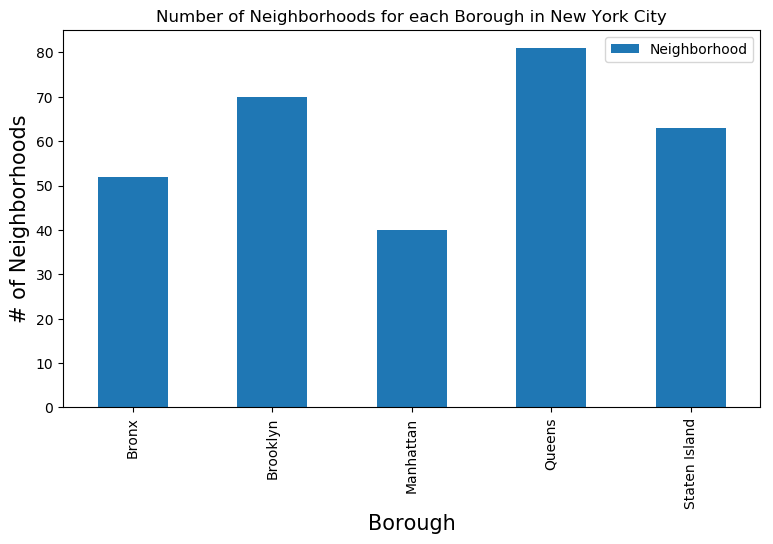

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
# x-axis
plt.xlabel('Borough', fontsize = 15)
# y-axis
plt.ylabel('# of Neighborhoods', fontsize=15)
# creating a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
# Legend
plt.legend()
# display the plot
plt.show()

From the chart above, we see that Queens has the greatest number of neighborhoods

Now let's collect the Chinese restaurants for each Neighborhood

In [10]:
# prepare a neighborhood list that contains chinese restaurants
column_names=['Borough','Neighborhood','ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']
    print('(',count,'/',len(new_york_data),')','Chinese Restaurants in '+Neighborhood+','+Borough+':'+str(len(chinese_restaurants)))
    for restaurant_detail in chinese_restaurants.values.tolist():
        id, name, category=restaurant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough, 'Neighborhood': Neighborhood,'ID': id,'Name':name}, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield,Bronx:2
( 2 / 306 ) Chinese Restaurants in Co-op City,Bronx:4
( 3 / 306 ) Chinese Restaurants in Eastchester,Bronx:1
( 4 / 306 ) Chinese Restaurants in Fieldston,Bronx:2
( 5 / 306 ) Chinese Restaurants in Riverdale,Bronx:1
( 6 / 306 ) Chinese Restaurants in Kingsbridge,Bronx:1
( 7 / 306 ) Chinese Restaurants in Marble Hill,Manhattan:1
( 8 / 306 ) Chinese Restaurants in Woodlawn,Bronx:0
( 9 / 306 ) Chinese Restaurants in Norwood,Bronx:2
( 10 / 306 ) Chinese Restaurants in Williamsbridge,Bronx:1
( 11 / 306 ) Chinese Restaurants in Baychester,Bronx:2
( 12 / 306 ) Chinese Restaurants in Pelham Parkway,Bronx:3
( 13 / 306 ) Chinese Restaurants in City Island,Bronx:1
( 14 / 306 ) Chinese Restaurants in Bedford Park,Bronx:2
( 15 / 306 ) Chinese Restaurants in University Heights,Bronx:0
( 16 / 306 ) Chinese Restaurants in Morris Heights,Bronx:4
( 17 / 306 ) Chinese Restaurants in Fordham,Bronx:2
( 18 / 306 ) Chinese Restaurants in East Tremont,Bronx:

Now that we have retrieved the Chinese Restaurants in New York City, we will analyze the results

In [11]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4e2710b7a809510950dd6b32,Double Dragon
2,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
3,Bronx,Co-op City,4fee4857e4b0f9bd2b5cd611,Chinese Buffet (All You Can Eat)
4,Bronx,Co-op City,4e4df7abbd4101d0d79f476b,China Top


In [12]:
chinese_rest_ny.shape

(413, 4)

There are 413 Chinese restaurants in New York City

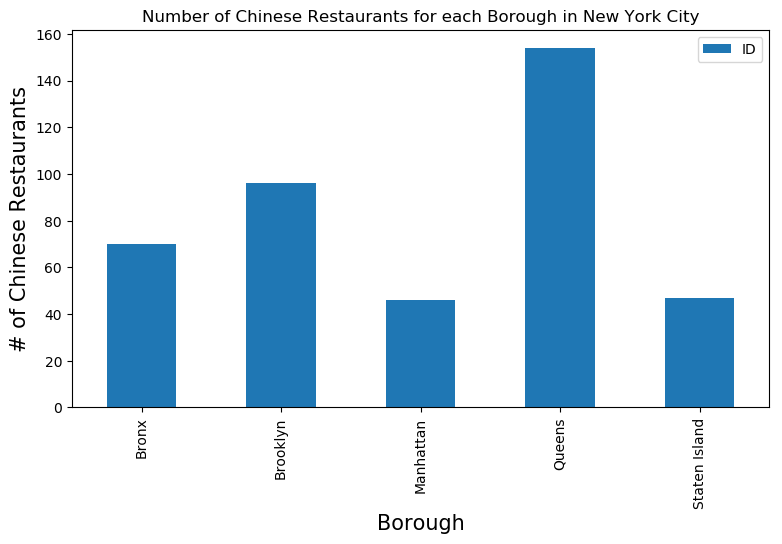

In [13]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Number of Chinese Restaurants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('# of Chinese Restaurants', fontsize = 15)
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

Queens, New York has the largest number of Chinese restaurants. Now let's find the Neighborhood in Queens with the largest number of Chinese restaurants

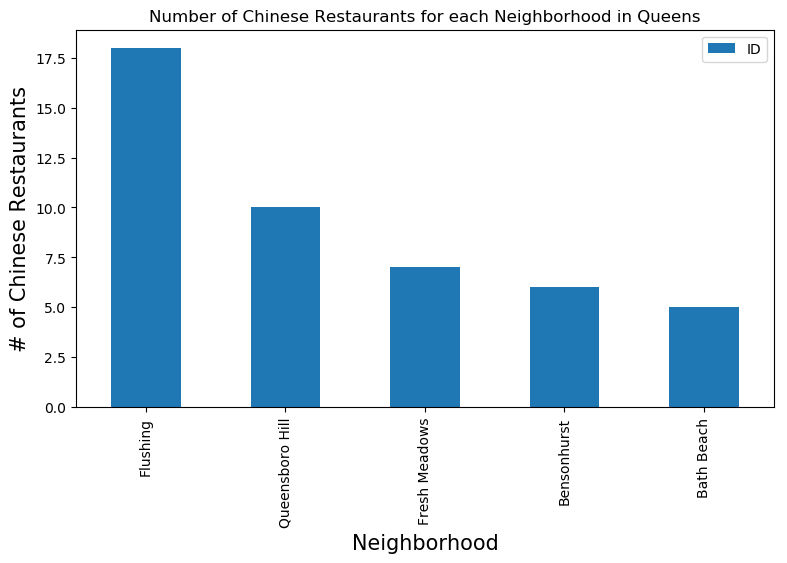

In [14]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Number of Chinese Restaurants for each Neighborhood in Queens')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('# of Chinese Restaurants', fontsize = 15)
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [15]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
182,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
183,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
184,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
185,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
186,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
187,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
188,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
189,Queens,Flushing,4af5fd0af964a520daff21e3,Hunan House Chinese Restaurant
190,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
191,Queens,Flushing,5990ab0a826444188d18dabc,Szechuan House


Flushing, Queens has the largest number of Chinese restaurants with 18. Now let's get the ranking for each restaurant

In [16]:
column_names=['Borough','Neighborhood','ID','Name','Rating']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in chinese_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name=row
    

column_names=['Borough','Neighborhood','ID','Name','Rating']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,rating=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        id,name,rating=[0]*3
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough':Borough,'Neighborhood':Neighborhood,'ID':id,'Name':name,'Rating':rating}, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4e2710b7a809510950dd6b32
( 2 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 3 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4fee4857e4b0f9bd2b5cd611
( 4 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4e4df7abbd4101d0d79f476b
( 5 / 413 ) processed
                         ID            Name  Rating
0  4c66dcfaaebea593955a74d0  Chinese Buffet     4.9
( 6 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 7 / 413 ) processed
Empty DataFrame
Columns: [ID, Name, Rating]
Index: []
No data available for id= 4cc4d337be40a35d390b814c
( 8 / 4

In [17]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Rating
0,Bronx,Wakefield,0,0,0
1,Bronx,Wakefield,0,0,0
2,Bronx,Co-op City,0,0,0
3,Bronx,Co-op City,0,0,0
4,Bronx,Co-op City,0,0,0


In [18]:
chinese_rest_stats_ny.shape

(413, 5)

In [19]:
chinese_rest_ny.shape

(413, 4)

In [28]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
Borough         413 non-null object
Neighborhood    413 non-null object
ID              413 non-null object
Name            413 non-null object
Rating          413 non-null object
dtypes: object(5)
memory usage: 16.2+ KB


In [29]:
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [30]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
Borough         413 non-null object
Neighborhood    413 non-null object
ID              413 non-null object
Name            413 non-null object
Rating          413 non-null float64
dtypes: float64(1), object(4)
memory usage: 16.2+ KB


In [31]:
# Restaurant  with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Rating                               9.2
Name: 153, dtype: object

Let's identify the Neighborhoods with maximum average rating 

In [34]:
nyc_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
nyc_neighborhood_stats.columns=['Neighborhood','Avg Rating']

In [35]:
nyc_neighborhood_stats.sort_values(['Avg Rating'],ascending=False).head(10)

,Neighborhood,Avg Rating
63,Flatiron,9.20
30,Chelsea,9.20
106,Long Island City,9.10
108,Lower East Side,9.00
51,East Village,8.95
195,West Village,8.95
76,Gramercy,8.95
134,Noho,8.95
120,Midtown South,8.90
188,Upper West Side,8.90


Now let's identify the average ratings by Borough

In [36]:
nyc_borough_stats=chinese_rest_stats_ny.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
nyc_borough_stats.columns=['Borough','Avg Rating']

In [37]:
nyc_borough_stats.sort_values(['Avg Rating'],ascending=False).head()

,Borough,Avg Rating
2,Manhattan,8.182609
1,Brooklyn,4.729167
3,Queens,4.473377
4,Staten Island,3.238298
0,Bronx,2.350000


Let's create a bar chart of this data

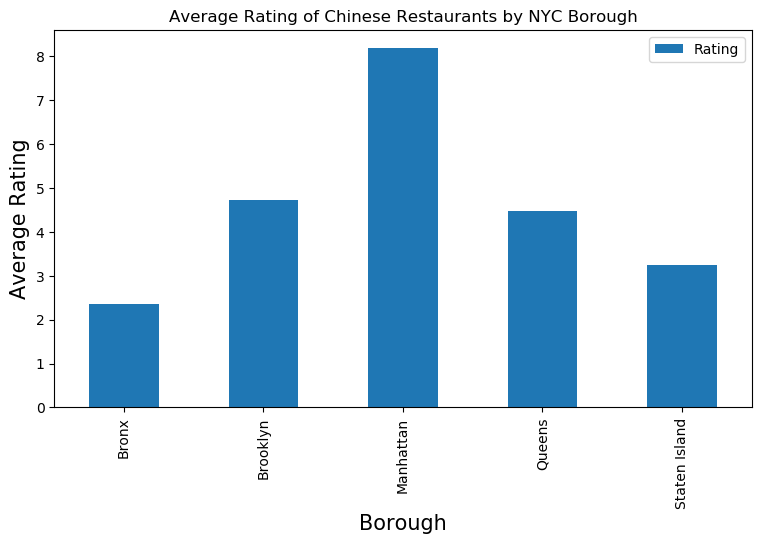

In [39]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Average Rating of Chinese Restaurants by NYC Borough')
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

Let's look for all neighborhoods with an average rating equal to and greater than 9.0

In [40]:
nyc_neighborhood_stats=nyc_neighborhood_stats[nyc_neighborhood_stats['Avg Rating']>=9.0]

In [41]:
nyc_neighborhood_stats

,Neighborhood,Avg Rating
30,Chelsea,9.2
63,Flatiron,9.2
106,Long Island City,9.1
108,Lower East Side,9.0


Now we will combine this data set withthe original new york dataset to get the latitude and longitudes

In [42]:
nyc_neighborhood_stats=pd.merge(nyc_neighborhood_stats,new_york_data, on='Neighborhood')

In [43]:
nyc_neighborhood_stats=nyc_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Avg Rating']]

In [44]:
nyc_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Avg Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.2
1,Staten Island,Chelsea,40.594726,-74.189560,9.2
2,Manhattan,Flatiron,40.739673,-73.990947,9.2
3,Queens,Long Island City,40.750217,-73.939202,9.1
4,Manhattan,Lower East Side,40.717807,-73.980890,9.0


Now let's map this data

In [66]:
ny_map=folium.Map(location=[40.693943, -73.985880], zoom_start=12)

In [67]:
incidents=folium.map.FeatureGroup()

for lat, lng, in nyc_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(folium.CircleMarker([lat,lng],radius=10,color='yellow',fill=True,fill_color='blue',fill_opacity=0.6))

In [68]:
nyc_neighborhood_stats['Label']=nyc_neighborhood_stats['Neighborhood']+','+nyc_neighborhood_stats['Borough']+'('+nyc_neighborhood_stats['Avg Rating'].map(str)+')'

In [69]:
for lat, lng, label in nyc_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat,lng], popup=label).add_to(ny_map)
ny_map.add_child(incidents)